#### 背景说明
近日，ChatGPT的横空出世使得人工智能再度成为公众关注焦点，作为一款人工智能聊天机器人，其通过大量的语料库进行模型训练，实现自身的语言理解和文本生成能力，为自然语言处理技术商业化落地打开了大门。</br>
通过“自助服务”+“人机协作”，对话式智能在企业中的应用可以在企业内部提供高效、高质量的服务，同时还可以创建标准化的知识库，以有效地管理相关业务知识和文档。作为自然语言处理的一种，智能问答系统可以根据历史问答形成的数据库，将文本转化为词向量进行相似度计算，找到和历史数据中相似度最高的问题，返回对应的答案，将其用来构建智能客服解决方案，可以满足企业在客服领域的需求，提高业务的运行效率。本次项目结合已有的问答数据进行训练，实现相似问题的自动回复。

#### 示例数据
本项目选取11000条通信行业业务相关的用户提问和回答数据，作为真实的问答数据集，具体字段说明和示例数据如下。</br>

| 字段      | 说明                                 |
| -------- | ---------------------------------------- |
| title    | 问题|
| question | 详细说明                             |
| reply    | 回答                                     |
| is_best  | 是否为最佳答案，1为最佳答案，0为普通答案 |




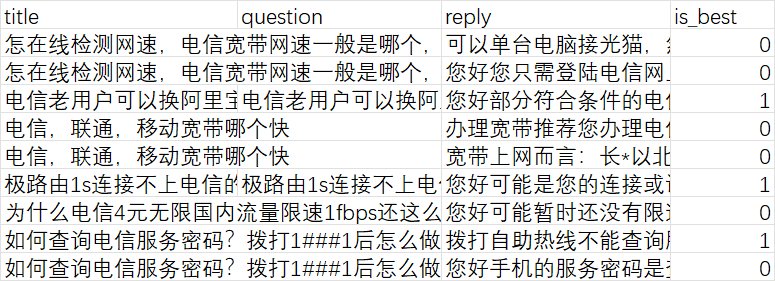


#### 分析思路
对每个问题只选取最好的回答，利用jieba分词器进行分词和清洗，利用余弦相似度找到相似度最高的问题，输出对应的答案。<br>
1.数据清洗：删除重复值和缺失值。<br>
2.文本清洗：利用结巴分词器进行分词，并去除停用词。<br>
3.词频展示：展示出现频率较高的词汇。<br>
4.文本相似度计算：计算问题之间的相似度。<br>
5.输出答案：根据问题间的相似度排序，输出问题和答案。

需要大段自己填写的特别多！整句的函数、for循环内容也要自己写！！！

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns  #绘图
import jieba.analyse
import csv
import re

In [2]:
## 读取csv文件前110000行数据
data = pd.read_csv("./modelqa.csv",nrows=110000)
data.head()

,title,question,reply,is_best
0,怎在线检测网速，电信宽带网速一般是哪个，电信宽,NaN,可以单台电脑接光猫，然后拨号上网，可以通过360卫士、电脑管家等第三方平台自带的测试带宽功能...,0
1,怎在线检测网速，电信宽带网速一般是哪个，电信宽,NaN,您好您只需登陆电信网上营业厅，然后进入宽带测速页面即可测试您的宽带网速等。电信新出流魔王卡每...,0
2,电信老用户可以换阿里宝卡的套餐吗？,电信老用户可以换阿里宝卡的套餐吗？电信现在套餐资费真比不上其他两家的，我现在用的大牛卡无限量...,您好部分符合条件的电信老用户是可以变更成互联网套餐的，不过阿里宝卡是联通手机卡，电信用户是不...,1
3,电信，联通，移动宽带哪个快,NaN,办理宽带推荐您办理电信宽带使用，电信宽带信号稳定网络速度快。由于中*电信的服务器、网络架设等...,0
4,电信，联通，移动宽带哪个快,NaN,宽带上网而言：长*以北用联通长*以南用电信中国移动的宽带就是搞笑的。手机4G而言，联通4G最...,0


## 1.数据清洗

In [3]:
## 只要最佳回答，选取is_best为1的列
data = data[data['is_best']==1]
data

,title,question,reply,is_best
2,电信老用户可以换阿里宝卡的套餐吗？,电信老用户可以换阿里宝卡的套餐吗？电信现在套餐资费真比不上其他两家的，我现在用的大牛卡无限量...,您好部分符合条件的电信老用户是可以变更成互联网套餐的，不过阿里宝卡是联通手机卡，电信用户是不...,1
5,极路由1s连接不上电信的光猫,极路由1s连接不上电信的光猫！路由器上设置完宽带账号密码就是拨号不成功！,您好可能是您的连接或设置不正确，您可以根据路由器的使用说明重新连接、设置试一下。电信新出流魔...,1
7,如何查询电信服务密码？拨打1###1后怎么做？,NaN,拨打自助热线不能查询服务密码的，直接致电中*电*的客服热线1####转接人工服务即可查询到，...,1
9,电信卡里积分怎么用,NaN,积分商城使用，参与活动抽奖，捐赠。每实际消费1元钱的电信业务积1分，奖励积分是额外赠送给客户...,1
11,安徽电信号码怎么查询流量使用情况,NaN,您好，可以下载安徽电信掌上1####客户端查询，步骤如下：第一：用手机号码服务密码或者随机码...,1
...,...,...,...,...
109991,为什么不开流量用WIFI上网还是会费流量欠话费,NaN,您好您可以凭手机服务密码登陆网上营业厅或掌上营业厅查询话费、流量使用情况，如有疑问可以拨打客...,1
109992,2014年办的电信宽带，当是是租的房子，用了2个月停机了就没在用了，一,2014年办的电信宽带，当是是租的房子，用了2个月停机了就没在用了，一直到今天打电话通知我减...,您好您办理宽带时应该是签订了在网协议，在协议期内一般是正常计费的，您可以到当地营业厅请工作人...,1
109993,电脑用的无线网络老是掉线是怎么回事,NaN,您好您可以把电脑直接连接宽带猫拨号上网试一下，如果上网正常，应该是您的路由器问题，您可以重新...,1
109995,手机欠费了，我用的是171的卡。用充值卡怎么能充进去话费,NaN,您好171号段的号码是虚拟运营商的号码，使用普通的充值卡是不能充值的，您可以登陆该虚拟运营商...,1


In [4]:
# 根据问题找答案，只要问题和回答两列
data = data[['title','reply']]
data.head()

,title,reply
2,电信老用户可以换阿里宝卡的套餐吗？,您好部分符合条件的电信老用户是可以变更成互联网套餐的，不过阿里宝卡是联通手机卡，电信用户是不...
5,极路由1s连接不上电信的光猫,您好可能是您的连接或设置不正确，您可以根据路由器的使用说明重新连接、设置试一下。电信新出流魔...
7,如何查询电信服务密码？拨打1###1后怎么做？,拨打自助热线不能查询服务密码的，直接致电中*电*的客服热线1####转接人工服务即可查询到，...
9,电信卡里积分怎么用,积分商城使用，参与活动抽奖，捐赠。每实际消费1元钱的电信业务积1分，奖励积分是额外赠送给客户...
11,安徽电信号码怎么查询流量使用情况,您好，可以下载安徽电信掌上1####客户端查询，步骤如下：第一：用手机号码服务密码或者随机码...


检验缺失值<br>

In [5]:
data.isna().sum() ## 检查缺失值

title    0
reply    2
dtype: int64

删除缺失值<br>

In [6]:
# 删除缺失值并检查
data = data.dropna() ## 删除缺失值
data.isna().sum() ## 检查缺失值

title    0
reply    0
dtype: int64

统计重复值

In [7]:
# 使用duplicated()检查title列内容是否重复，并统计True和False值
data['title'].duplicated().value_counts() ##检查重复值，并对每项进行计数

False    60793
True      2058
Name: title, dtype: int64

删除重复值

In [8]:
data = data.drop_duplicates('title',keep='first') ## 按title列删除重复项，仅保留首次出现的问答数据
data

,title,reply
2,电信老用户可以换阿里宝卡的套餐吗？,您好部分符合条件的电信老用户是可以变更成互联网套餐的，不过阿里宝卡是联通手机卡，电信用户是不...
5,极路由1s连接不上电信的光猫,您好可能是您的连接或设置不正确，您可以根据路由器的使用说明重新连接、设置试一下。电信新出流魔...
7,如何查询电信服务密码？拨打1###1后怎么做？,拨打自助热线不能查询服务密码的，直接致电中*电*的客服热线1####转接人工服务即可查询到，...
9,电信卡里积分怎么用,积分商城使用，参与活动抽奖，捐赠。每实际消费1元钱的电信业务积1分，奖励积分是额外赠送给客户...
11,安徽电信号码怎么查询流量使用情况,您好，可以下载安徽电信掌上1####客户端查询，步骤如下：第一：用手机号码服务密码或者随机码...
...,...,...
109991,为什么不开流量用WIFI上网还是会费流量欠话费,您好您可以凭手机服务密码登陆网上营业厅或掌上营业厅查询话费、流量使用情况，如有疑问可以拨打客...
109992,2014年办的电信宽带，当是是租的房子，用了2个月停机了就没在用了，一,您好您办理宽带时应该是签订了在网协议，在协议期内一般是正常计费的，您可以到当地营业厅请工作人...
109993,电脑用的无线网络老是掉线是怎么回事,您好您可以把电脑直接连接宽带猫拨号上网试一下，如果上网正常，应该是您的路由器问题，您可以重新...
109995,手机欠费了，我用的是171的卡。用充值卡怎么能充进去话费,您好171号段的号码是虚拟运营商的号码，使用普通的充值卡是不能充值的，您可以登陆该虚拟运营商...


## 2.文本清洗

编译正则表达式

In [9]:
import jieba

#用正则表达式移除特殊符号
def remove_punc(line_sentence):
    # 判断字符串为空的情况
    if line_sentence.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]") # 编译正则表达式
    line = rule.sub('',line_sentence) # 替换匹配项
    return line

In [10]:
#停用词列表
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()] #打开停用词表，按行读取停用词
    return stopwords  

#加载停用词
stopwords = stopwordslist("./stop_words.txt")

#### 分词，去除停用词

结巴分词

In [11]:
# 定义分词，去除停用词函数。先分词，然后根据停用词表去除停用词
def cut_words(sentence):
    word_list =[]
    words = jieba.cut(remove_punc(sentence))  ## 使用结巴分词器精准模式分词（生成器方式）
    
    ## 根据停用词表去除停用词，若数据中相应词在停用词表中，则去除，若不在则保留至word_list中
    for word in words:
        if word not in stopwords:
            word_list.append(word)

    return word_list

In [ ]:
# 调用cut_words()函数处理title中的每条数据
question_titles = list(data.title) # 将处理的数据，即dataframe中title列转换为列表
result_titles = []
texts = ''
# 对question_titles中的每条数据进行分词操作
for item in question_titles:
    result_titles.append(" ".join(cut_words(item))) # 对每条文本数据进行分词，用空格分割，结果添加进result_titles
    texts += " ".join(cut_words(item)) # 对每条数据都进行分词，结果全部存入texts，用作词云展示

# 打印结果（检查）；别打印了，会很卡；要打印也别打印全部
# print(result_titles) 
print(question_titles[:10])

In [13]:
texts[:100]

'电信 老 用户 换 阿里 宝卡 套餐极 路由 1s 连接 不上 电信 光猫查询 电信服务 密码 拨打 11 做电信卡 里 积分安徽 电信 号码 查询 流量 情况安徽 电信 手机 办理 流量 包安徽 电'

## 3.词频展示

根据文本生成词云<br>

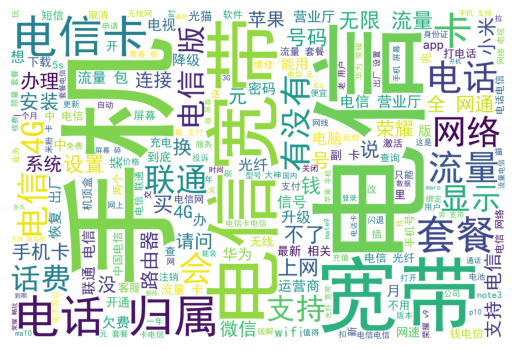

In [14]:
# 对全部数据分词、去停用词后生成词云
from wordcloud import WordCloud

# 设置词云对象
word = WordCloud(font_path='simhei.ttf', 
                 background_color="white",
                 width=1200,
                 height=800,
                )
word.generate(texts) ## 加载文本内容到词云对象中

# 显示词云
plt.imshow(word) # 用plt显示图片
plt.axis("off") # 不显示坐标轴
plt.show() # 显示图片

基于Textrank的关键词提取

In [15]:
# 主题词提取
def textrank_words(line):
    line = remove_punc(line) # 去特殊符号
    line = line.strip() # 去首尾空格
    line_words =""
    for word,x in jieba.analyse.textrank(line.strip(), withWeight=True): ## 基于Textrank的关键词提取(数据，权重)
        if word.strip()=="": 
            continue
        line_words = line_words + (word + " ")
    return line_words


result_titles = []  #建立存储分词的列表
# 对问题（title）列的每个数据进行关键词提取
for item in question_titles:
    rank_result = textrank_words(item)
    if len(rank_result)>0: 
        result_titles.append(rank_result) # 向result_titles中插入关键词提取的结果
print(result_titles[:10])

['电信 用户 ', '连接 电信 光猫 路由 ', '电信服务 查询 拨打 密码 ', '查询 流量 号码 电信 使用 安徽 情况 ', '手机 电信 流量 安徽 办理 ', '手机 账单 电信 查询 安徽 ', '穿墙 信号 ', '有没有 市面上 ', '电信 收费 ', '苹果 电信卡 支持 ']


基于tf-idf关键词提取

In [16]:
# 主题词提取
def tfidf_words(line):
    line = remove_punc(line) # 去特殊符号
    line = line.strip() # 去首尾空格
    line_words =""
    ## 基于TF-IDF的关键词提取(数据，权重)，使用默认的TF-IDF模型对数据进行分析
    for word,x in jieba.analyse.extract_tags(line.strip(),withWeight=True):
        if word.strip()=="": 
            continue
        line_words = line_words + (word + " ")
    return line_words


result_titles = []  #建立存储分词的列表
# 对问题（title）列的每个数据进行关键词提取
for item in question_titles:
    rank_result = tfidf_words(item)
    if len(rank_result)>0: 
        result_titles.append(rank_result)  # 向result_titles中插入关键词提取的结果
print(result_titles[:10])

['宝卡 套餐 阿里 电信 用户 可以 ', '1s 不上 光猫 路由 电信 连接 ', '11 电信服务 拨打 查询 密码 如何 怎么 ', '电信卡 积分 怎么 ', '号码 查询 电信 流量 安徽 使用 怎么 情况 ', '电信 流量 安徽 办理 手机 怎么 ', '账单 查询 电信 安徽 手机 怎么 ', '穿墙 电信宽带 怎么样 信号 ', '卡多待 市面上 电信 有没有 ', '流牛卡 电信 收费 多少 ']


#### 出现频率最多的单词，绘制成柱状图

词袋模型训练，转换

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# 定义函数，对分词后的单词个数累加排序，计算出现最频繁的单词
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus) ## 词袋模型训练
    bag_of_words = vec.transform(corpus) ## 词袋模型转换
    sum_words = bag_of_words.sum(axis=0) # 按列相加，即每条文本词个数的求和
    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] # 获取词袋模型的词典并返回键值对，用for循环遍历提取。索引与sum_words匹配获取词频
    words_freq =sorted(words_freq, key = lambda x: x[1],reverse=True) # 按照词频进行降序排列
    return words_freq[:n]
# 返回前20个最高词频的词和对应次数
top_words = get_top_n_words(result_titles, n=20)
print(top_words)

[('电信', 17664), ('怎么', 9326), ('手机', 8561), ('什么', 7136), ('多少', 5068), ('可以', 4134), ('华为', 4092), ('电话', 4053), ('电信卡', 3846), ('宽带', 3832), ('电信宽带', 3374), ('流量', 3255), ('哪个', 3133), ('苹果', 2967), ('移动', 2523), ('套餐', 2262), ('荣耀', 2239), ('小米', 2183), ('为什么', 2150), ('哪里', 2043)]


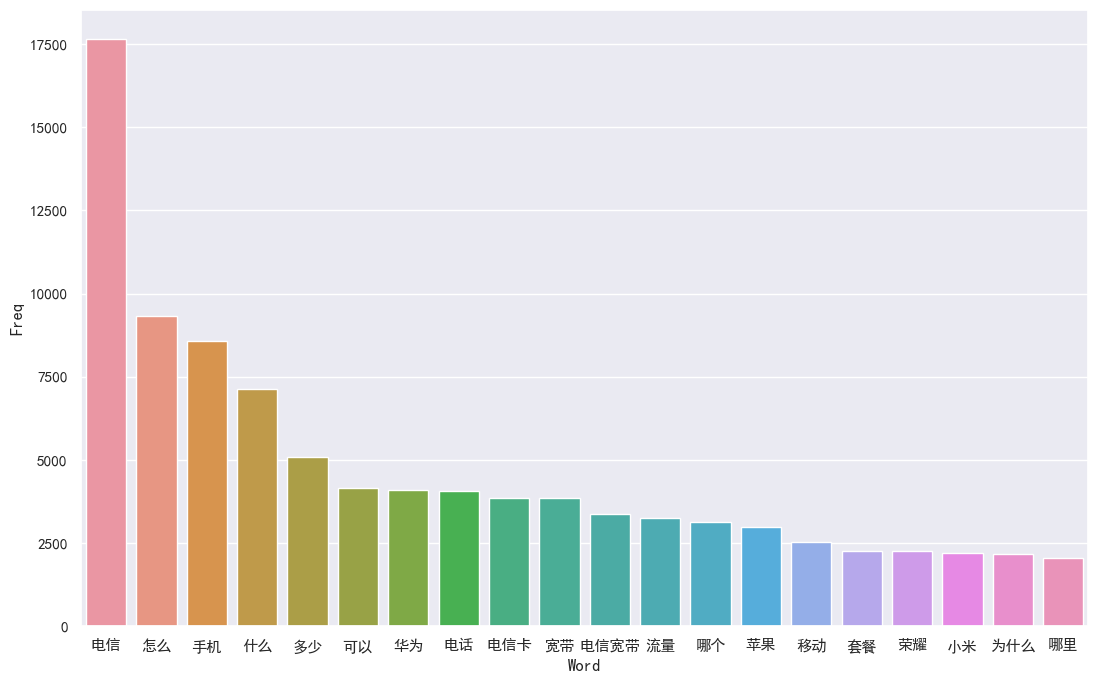

In [18]:
top_words = pd.DataFrame(top_words)   # top_words转化为dataframe
top_words.columns=["Word", "Freq"] # 添加列名

# seaborn绘制直方图
sns.set(rc={'figure.figsize':(13,8)})
plt.rcParams['font.sans-serif'] = ['SimHei']  #中文显示代码
g = sns.barplot(x="Word", y="Freq", data=top_words)
g.set_xticklabels(g.get_xticklabels(), rotation=0,)  #刻度
plt.show()

## 4.文本相似度计算

tf-idf训练转换

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer =  TfidfVectorizer() # 使用tfidf

tfidf_matrix = []
for item in question_titles:
    tfidf_matrix.append(" ".join(cut_words(item))) # 对问题（title）进行分词，去停用词，得到结果插入tfidf_matrix
vectorizer = vectorizer.fit(tfidf_matrix) ## 对tfidf_matrix进行tfidf训练

tfidf_matrix = vectorizer.transform(tfidf_matrix) ## 对训练后的tfidf_matrix进行转换
tfidf_matrix

<60793x25328 sparse matrix of type '<class 'numpy.float64'>'
	with 251485 stored elements in Compressed Sparse Row format>

得到的是稀疏矩阵，计算相似度时转化为array()

余弦相似度计算

In [20]:
# 余弦相似性计算
def cos_distance(vector1, vector2):
    vec1 = np.array(vector1)
    vec2 = np.array(vector2)
    ## 计算余弦相似度，cos∠= (a*b)/(||a||*||b||)
    cosine = float(np.sum(vec1 * vec2)) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return cosine 
# 计算相似度
def sim_words(vec, vecs_list):
    similarity_list = []
    for vec_i in vecs_list: # vecs_list是所有问题（title）的tf-idf值，用来和要搜索的问题做比较，看相似
        similarity = cos_distance(vec, vec_i) # 计算余弦相似度
        similarity_list.append(similarity) # 计算结果插入similarity_list
    return similarity_list

降低数组维度

In [21]:
# 定义函数，要求输入的“问题”要和所有数据一样，转化为tfidf
def vec(sent):
    sent = " ".join(cut_words(sent)) # 分词，去停用词
    sent_countvec = vectorizer.transform([sent]) ## 对转化为list格式句子进行tfidf转换
    sent_countvec = np.squeeze(sent_countvec.toarray()) # 将转为tfidf的数据转化为数组后降低一个维度
    return sent_countvec

将相应问题按照相似度降序排序

In [22]:
# 将输入的“问题”进行相似度计算，排序后按照“索引”在data中找到相应title（问题）和reply（回复）
def question_reply(user_question, n=5):    
    similarity_lists = sim_words(vec(user_question),tfidf_matrix.toarray()) # 将输入单个问题与所有问题之间计算相似度
    # 计算similarity_lists时只得到相似度，但数据是按照顺序计算的，所以进行遍历即得到“索引”
    ## 遍历similarity_lists，得到（“索引”，相似度），按照相似度的值进行降序排列
    sorted_res = sorted(enumerate(similarity_lists), key=lambda x: x[1], reverse=True)
    
    # 将问题和回复转为列表形式
    question_reply = list(data.reply) 
    question_titles = list(data.title)
    
    q_r = []
    for i in sorted_res[:n]:
        q = question_titles[i[0]] # 按照索引在原数据中找到 data.title
        r = question_reply[i[0]] # 按照索引在原数据中找到 data.reply
        q_r.append((q ,r))
    return q_r

## 5.输出答案

In [23]:
# 输入问题即可获得相似问题和答案
question_reply('怎么设置无线',2)

/tmp/ipykernel_5124/4266845341.py:6: RuntimeWarning: invalid value encountered in double_scalars
  cosine = float(np.sum(vec1 * vec2)) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


[('电信的无线光纤猫怎么设置无线路由器', '您好您可以根据路由器的使用说明连接路由器和光纤猫，然后进入路由器设置页面设置即可。'),
 ('手机移动宽带怎么设置无线路由器设置',
  '工具/原料：手机，路由器，宽带猫，网线。说明：路由器的登录地址和登录密码一般是192.168.1.1，admin，不过不是所有路由器都是这个登录地址和密码，有些路由器登录密码是没有默认密码的，首次使用需要自行设置，具体的路由器登录地址和密码可以翻看路由器背面的小标签，或者直接查阅路由器的说明书。手机设置路由器的方法如下：1、首先将路由器和宽带猫使用网线连接起来，连接方法是通过网线将宽带猫的lan口和路由器的wan口连接。2、硬件连接完毕后，使用手机连接上这款路由器的无线信号，然后打开手机浏览器，输入路由器的登录地址和登录密码，登录后台后选择快速设置。3、然后根据要求填写宽带帐号和密码。4、然后在设置一下无线名称和密码保存然后路由器即可正常使用。')]